# CPE 487 587 Deep Learning for Engineering Applications
## Instructor: Rahul Bhadani
## Chapter 3: Introducing Neural Networks

In [2]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# 1. Vector of Partial Derivatives using Torch

## Example 1: Single Point

$$F: \mathbb{R}^2 \to \mathbb{R}$$

$$
f(x, y) = x^2 + 3xy + y^2
$$

In [4]:
# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [15]:
# Value at which I will compute the gradient
x = torch.tensor(2.0, device=device, requires_grad=True)
y = torch.tensor(3.0, device=device, requires_grad=True)

In [16]:
f = x**2 + 3*x*y + y**2

In [17]:
print(f"\nFunction: f(x, y) = x^2 + 3xy + y^2")
print(f"Point: (x={x.item()}, y={y.item()})")
print(f"f(x, y) = {f.item():.4f}")


Function: f(x, y) = x^2 + 3xy + y^2
Point: (x=2.0, y=3.0)
f(x, y) = 31.0000


In [18]:
f

tensor(31., device='cuda:0', grad_fn=<AddBackward0>)

In [19]:
# Backward pass: compute gradients via autograd, you can only run this once!
f.backward()

In [20]:
print(f"\nAutomatic Differentiation Results:")
print(f"df/dx = {x.grad.item():.4f}")
print(f"df/dy = {y.grad.item():.4f}")
print(f"\nGradient vector grad f = [{x.grad.item():.4f}, {y.grad.item():.4f}]")


Automatic Differentiation Results:
df/dx = 13.0000
df/dy = 12.0000

Gradient vector grad f = [13.0000, 12.0000]


## Example 2: As a vector-valued input

In [5]:
x = torch.tensor([1.0, 2.0, 3.0], device=device, requires_grad=True)
f = x[0]**2 + x[1]*x[2] + torch.sin(x[0])

In [30]:
# Compute gradient via autograd
f.backward()

print(f"\nGradient of f via autograd:")
print(f"df/dx1 = {x.grad[0].item():.6f}")
print(f"df/dx2 = {x.grad[1].item():.6f}")
print(f"df/dx3 = {x.grad[2].item():.6f}")
print(f"\ngrad f = {x.grad.cpu().detach().numpy()}")

# Analytical verification
print(f"\nAnalytical verification:")
print(f"df/dx1 = 2x1 + cos(x1) = 2(1) + cos(1) = {2*1 + np.cos(1):.6f} ")
print(f"df/dx2 = x3 = {3:.6f} ")
print(f"df/dx3 = x2 = {2:.6f} ")


Gradient of f via autograd:
df/dx1 = 2.540302
df/dx2 = 3.000000
df/dx3 = 2.000000

grad f = [2.5403023 3.        2.       ]

Analytical verification:
df/dx1 = 2x1 + cos(x1) = 2(1) + cos(1) = 2.540302 
df/dx2 = x3 = 3.000000 
df/dx3 = x2 = 2.000000 


## Example 3: We are interested in computing gradient for  multiple points at once

$$F: \mathbb{R}^2 \to \mathbb{R}$$

$$ f(\mathbf{x}, \mathbf{y}) = \mathbf{x}^2 + \mathbf{y}^2$$

In [35]:
points = torch.tensor([
            [1.0, 2.0],
            [2.0, 3.0],
            [3.0, 1.0],
            [0.5, 1.5],
        ], device=device, requires_grad=True)

In [36]:
#f(x, y) = x^2 + y^2
f = (points[:, 0]**2 + points[:, 1]**2).sum()

### Why we need `sum()`

$$Loss = f_1(x_1, y_1) + f_2(x_2, y_2) + f_3(x_3, y_3)$$

$$\frac{\partial Loss}{\partial x_1} = \frac{\partial f_1}{\partial x_1} \quad \text{(only depends on first function!)}$$
$$\frac{\partial Loss}{\partial y_1} = \frac{\partial f_1}{\partial y_1}$$

$$\frac{\partial Loss}{\partial x_2} = \frac{\partial f_2}{\partial x_2} \quad \text{(only depends on second function!)}$$
$$\frac{\partial Loss}{\partial y_2} = \frac{\partial f_2}{\partial y_2}$$

$$\frac{\partial Loss}{\partial x_3} = \frac{\partial f_3}{\partial x_3} \quad \text{(only depends on third function!)}$$
$$\frac{\partial Loss}{\partial y_3} = \frac{\partial f_3}{\partial y_3}$$

In [37]:
print(f"\nFunction: f(x, y) = x^2 + y^2")
print(f"Batch of 4 points:")
print(points.cpu().detach().numpy())
        


Function: f(x, y) = x^2 + y^2
Batch of 4 points:
[[1.  2. ]
 [2.  3. ]
 [3.  1. ]
 [0.5 1.5]]


In [38]:
f.backward()

In [40]:
print(points.grad.cpu().detach().numpy())

[[2. 4.]
 [4. 6.]
 [6. 2.]
 [1. 3.]]


In [42]:
for i, (point, grad) in enumerate(zip(points.detach(), points.grad)):
            print(f"Point {i+1}: ({point[0].item():.1f}, {point[1].item():.1f}) --> "
                f"grad f = ({grad[0].item():.2f}, {grad[1].item():.2f})")


Point 1: (1.0, 2.0) --> grad f = (2.00, 4.00)
Point 2: (2.0, 3.0) --> grad f = (4.00, 6.00)
Point 3: (3.0, 1.0) --> grad f = (6.00, 2.00)
Point 4: (0.5, 1.5) --> grad f = (1.00, 3.00)


## Example 4: Jacobian Matrix - Vector-Valued Functions

$$F: \mathbb{R}^2 \to \mathbb{R}^3$$

$$f_1(x, y) = x^2 + y^2$$
$$f_2(x, y) = xy$$
$$f_3(x, y) = \sin(x) + \cos(y)$$

In [43]:
def F(points):
    # points is a tensor of shape (2,)
    x, y = points[0], points[1]
    
    f1 = x**2 + y**2
    f2 = x * y
    f3 = torch.sin(x) + torch.cos(y)
    
    return torch.stack([f1, f2, f3])

In [44]:
x = torch.tensor(1.0, device=device, requires_grad=True)
y = torch.tensor(2.0, device=device, requires_grad=True)

In [47]:
print(f"\nVector Function: F(x, y) = [x^2 + y^2, xy, sin(x) + cos(y)]")
print(f"Input: (x={x.item()}, y={y.item()})")

f_outputs = F(x, y)
print(f"F(x, y) = {f_outputs.cpu().detach().numpy()}")


Vector Function: F(x, y) = [x^2 + y^2, xy, sin(x) + cos(y)]
Input: (x=1.0, y=2.0)
F(x, y) = [5.        2.        0.4253242]


In [48]:
# Compute Jacobian by backprop for each output
jacobian = torch.zeros(3, 2, device=device)

In [50]:
for i in range(3):
    # Reset gradients
    if x.grad is not None:
        x.grad.zero_()
    if y.grad is not None:
        y.grad.zero_()
    
    # Recompute outputs
    f_outputs = F(x, y)
    
    # Backprop for i-th output
    f_outputs[i].backward()
    
    # Store gradients in Jacobian
    jacobian[i, 0] = x.grad
    jacobian[i, 1] = y.grad

print(f"\nJacobian Matrix J = dF/d(x,y):")
print(jacobian.cpu().detach().numpy())
print(f"\nInterpretation (rows=outputs, columns=inputs):")
print(f"df1/dx = {jacobian[0, 0].item():.4f},  df1/dy = {jacobian[0, 1].item():.4f}")
print(f"df2/dx = {jacobian[1, 0].item():.4f},  df2/dy = {jacobian[1, 1].item():.4f}")
print(f"df3/dx = {jacobian[2, 0].item():.4f},  df3/dy = {jacobian[2, 1].item():.4f}")



Jacobian Matrix J = dF/d(x,y):
[[ 2.          4.        ]
 [ 2.          1.        ]
 [ 0.5403023  -0.90929747]]

Interpretation (rows=outputs, columns=inputs):
df1/dx = 2.0000,  df1/dy = 4.0000
df2/dx = 2.0000,  df2/dy = 1.0000
df3/dx = 0.5403,  df3/dy = -0.9093


## Example 5: Computing Jacobian for multiple points for Vector-valued

$$F: \mathbb{R}^2 \to \mathbb{R}^3$$

$$f_1(\mathbf{x}, \mathbf{y}) = \mathbf{x}^2 + \mathbf{y}^2$$
$$f_2(\mathbf{x}, \mathbf{y}) = \mathbf{x}\mathbf{y}$$
$$f_3(\mathbf{x}, \mathbf{y}) = \sin(\mathbf{x}) + \cos(\mathbf{y})$$

In [29]:
from torch.func import vmap, jacrev

In [28]:
# Define your specific F: R^2 -> R^3
def F(points):
    # points is a tensor of shape (2,)
    x, y = points[0], points[1]
    
    f1 = x**2 + y**2
    f2 = x * y
    f3 = torch.sin(x) + torch.cos(y)
    
    return torch.stack([f1, f2, f3])

In [30]:
# Create a batch of (x, y) coordinates
# Shape: (Batch, 2)
batch_points = torch.tensor([
    [1.0, 2.0],
    [0.0, torch.pi],
    [0.5, 0.5]
], device=device)

# Compute the batch Jacobian
# jacrev(F) calculates the 3x2 matrix
# vmap handles the batch dimension
batch_jac = vmap(jacrev(F))(batch_points)

print(f"Batch Jacobian Shape: {batch_jac.shape}") # torch.Size([3, 3, 2])
print("Jacobian for the first point (1.0, 2.0):")
print(batch_jac[0])

Batch Jacobian Shape: torch.Size([3, 3, 2])
Jacobian for the first point (1.0, 2.0):
tensor([[ 2.0000,  4.0000],
        [ 2.0000,  1.0000],
        [ 0.5403, -0.9093]], device='cuda:0')


In [ ]:
print("Jacobian for the second point:")
print(batch_jac[1])

Batch Jacobian Shape: torch.Size([3, 3, 2])
Jacobian for the second point:
tensor([[0.0000e+00, 6.2832e+00],
        [3.1416e+00, 0.0000e+00],
        [1.0000e+00, 8.7423e-08]], device='cuda:0')


In [32]:
print("Jacobian for the third point:")
print(batch_jac[2])

Jacobian for the third point:
tensor([[ 1.0000,  1.0000],
        [ 0.5000,  0.5000],
        [ 0.8776, -0.4794]], device='cuda:0')


# 2. Gradient Vector Visualization

$$

f(x, y) = sin(x) * cos(y)

$$

Gradient vector is

$$
\nabla f = \begin{bmatrix}\frac{\partial f}{\partial x} & \frac{\partial f}{\partial y}\end{bmatrix}
$$

Gradient vector evaluated at multiple points give rise to gradient vector field. If you are looking at the surface of a function, the gradient at a point always points toward the highest nearby point. If you are looking at a contour diagram, the gradient is always perpendicular to the contours. 

Source: https://citadel.sjfc.edu/faculty/kgreen/vector/block2/pder/node8.html

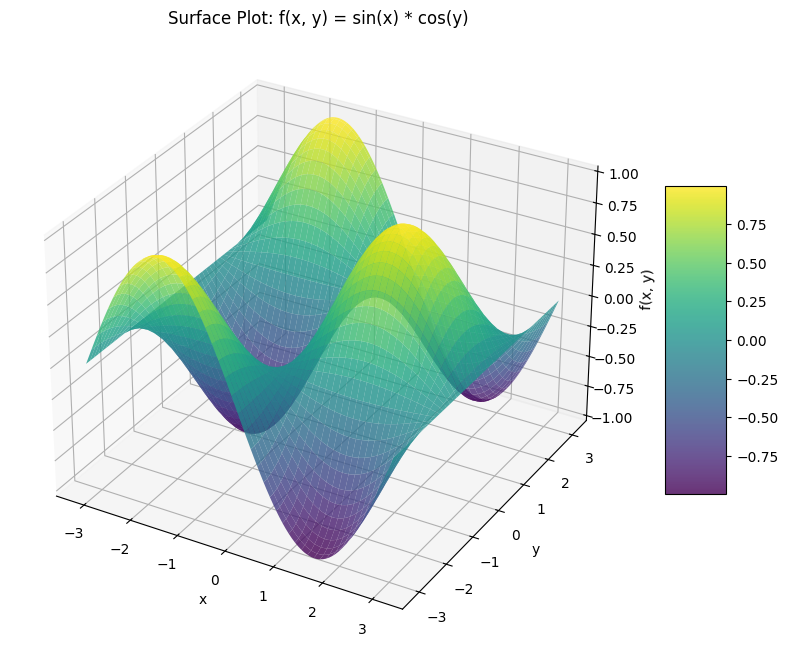

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


x = np.linspace(-np.pi, np.pi, 100)
y = np.linspace(-np.pi, np.pi, 100)
X, Y = np.meshgrid(x, y)

# Calculate z values using the function f(x, y) = sin(x) * cos(y)
Z = np.sin(X) * np.cos(Y)
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, Z, cmap='viridis', alpha=0.8, edgecolor='none')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('f(x, y)')
ax.set_title('Surface Plot: f(x, y) = sin(x) * cos(y)')

fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
plt.show()



In [5]:
import plotly.graph_objects as go
fig = go.Figure(data=[go.Surface(
    x=X,
    y=Y,
    z=Z,
    colorscale='Viridis',
    colorbar=dict(title='f(x, y)')
)])

# Update layout
fig.update_layout(
    title='Interactive Surface Plot: f(x, y) = sin(x) * cos(y)',
    scene=dict(
        xaxis_title='x',
        yaxis_title='y',
        zaxis_title='f(x, y)',
        camera=dict(
            eye=dict(x=1.5, y=1.5, z=1.3)
        )
    ),
    width=1000,
    height=800
)

# Show the interactive plot
fig.show()

## Gradient computation and visualization

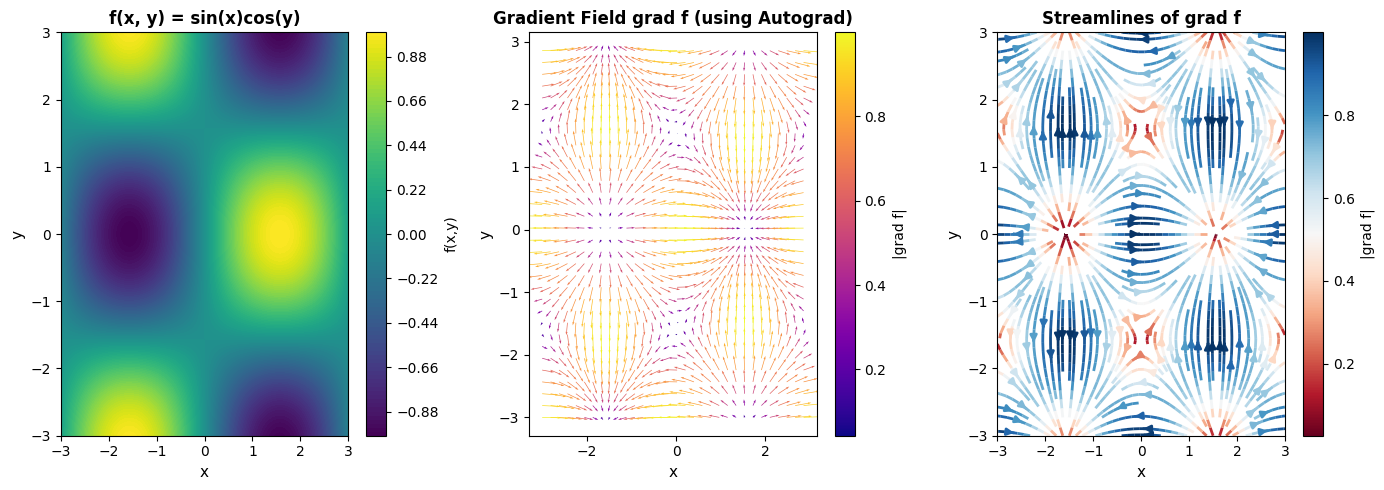

In [91]:
# Create grid of points
n_points = 128
x_vals = torch.linspace(-3, 3, n_points, device=device)
y_vals = torch.linspace(-3, 3, n_points, device=device)
X, Y = torch.meshgrid(x_vals, y_vals, indexing='ij')

x_flat = X.flatten().requires_grad_(True)
y_flat = Y.flatten().requires_grad_(True)
        
f = torch.sin(x_flat) * torch.cos(y_flat)
f_sum = f.sum()

f_sum.backward()

grad_x = x_flat.grad.detach().cpu().numpy().reshape(n_points, n_points)
grad_y = y_flat.grad.detach().cpu().numpy().reshape(n_points, n_points)

# Create visualization
fig, axes = plt.subplots(1, 3, figsize=(14, 5))

# Move to CPU for plotting
X_cpu = X.cpu().numpy()
Y_cpu = Y.cpu().numpy()
f_vals = np.sin(X_cpu) * np.cos(Y_cpu)

# Plot 1: Function values
contour = axes[0].contourf(X_cpu, Y_cpu, f_vals, levels=n_points, cmap='viridis')
axes[0].set_title('f(x, y) = sin(x)cos(y)', fontsize=12, fontweight='bold')
axes[0].set_xlabel('x', fontsize=11)
axes[0].set_ylabel('y', fontsize=11)
plt.colorbar(contour, ax=axes[0], label='f(x,y)')

# Plot 2: Gradient field
magnitude = np.sqrt(grad_x**2 + grad_y**2)
quiv = axes[1].quiver(X_cpu[::4, ::4], Y_cpu[::4, ::4], grad_x[::4, ::4], grad_y[::4, ::4], magnitude[::4, ::4], cmap='plasma',  scale=15)
axes[1].set_title('Gradient Field grad f (using Autograd)', fontsize=12, fontweight='bold')
axes[1].set_xlabel('x', fontsize=11)
axes[1].set_ylabel('y', fontsize=11)
plt.colorbar(quiv, ax=axes[1], label='|grad f|')

# Plot 3: Streamlines
# Create a finer grid for smoother streamlines
n_stream = 128
x_stream = np.linspace(-3, 3, n_stream)
y_stream = np.linspace(-3, 3, n_stream)
X_stream, Y_stream = np.meshgrid(x_stream, y_stream)

# Compute gradient on finer grid
grad_x_stream = np.cos(X_stream) * np.cos(Y_stream)
grad_y_stream = -np.sin(X_stream) * np.sin(Y_stream)

# varying linewidth of streamlines
magnitude = np.sqrt(grad_x_stream**2 + grad_y_stream**2)
#lw = 0.5 + 1.5 * (magnitude / (magnitude.max() + 1e-10))
lw =2
# Create streamplot
stream = axes[2].streamplot(X_stream, Y_stream, grad_x_stream, grad_y_stream, 
                            linewidth=lw, color=np.sqrt(grad_x_stream**2 + grad_y_stream**2),
                            cmap='RdBu', density=1.5)
axes[2].set_title('Streamlines of grad f', fontsize=12, fontweight='bold')
axes[2].set_xlabel('x', fontsize=11)
axes[2].set_ylabel('y', fontsize=11)
cbar = plt.colorbar(stream.lines, ax=axes[2], label='|grad f|')


plt.tight_layout()

plt.savefig('auto_grad_vector_field.png', dpi=300, bbox_inches='tight')

plt.show()

Streamlines, or more generally field lines, are tangent to the vector field in each point.

### More ways to visualize vector field using Line integral convolution

In LIC, discrete numerical integration is performed along the vector field's streamlines, which are traced on a uniform grid. This process effectively convolves a filter kernel with an input texture, typically white noise, to produce the final visualization. This generates a characteristic streaking texture that aligns with the flow direction, vividly revealing patterns like eddies and divergences. Consequently, LIC is particularly valuable for visualizing complex fluid dynamics, steady vector fields, and weather data.


Source: https://en.wikipedia.org/wiki/Line_integral_convolution

Line Integral Convolution is a texture-based technique for visualizing 2D/3D vector fields. It reveals flow structure by:

- Creating white noise - Random texture I(x, y)
- Following streamlines - Tracing paths through the vector field
- Convolving along paths - Averaging texture values along each streamline
- Producing output - Dense, structure-revealing visualization

Quiver plots are discrete where it is difficult to see continuous flow patterns. They also hide small-scale structures. LIC reveals structure at all scales. 



**From  https://scipy-cookbook.readthedocs.io/items/LineIntegralConvolution.html**:

Line integral convolution is a technique, or family of techniques, for representing two-dimensional vector fields. The idea is to produce a texture which is highly correlated in the direction of the vector field but not correlated across the vector field. This is done by generating a noise texture then, for each pixel of the image, "flowing" forward and back along the vector field. The points along this path are looked up in the noise texture and averaged to give the LIC texture at the starting point. The basic technique ignores both the magnitude of the vector field and its sign. With a minor modification the same technique can be used to produce an animation of "flow" along the vector field.

Additional references:
- https://github.com/alexus37/licplot
- https://courses.cms.caltech.edu/cs176/2006projects/project6/SC-94-37.pdf

In [86]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def lic_pytorch(vx, vy, noise_texture=None, kernel_length=31, num_steps=20):
    """
    GPU-accelerated LIC using PyTorch.
    
    Parameters:
    -----------
    vx, vy : 2D arrays or tensors
        Velocity field components
    """
    # Convert to tensors
    if not isinstance(vx, torch.Tensor):
        vx = torch.from_numpy(vx).float()
    if not isinstance(vy, torch.Tensor):
        vy = torch.from_numpy(vy).float()
    
    vx = vx.to(device)
    vy = vy.to(device)
    
    height, width = vx.shape
    
    # Generate noise if not provided
    if noise_texture is None:
        noise_texture = torch.rand(height, width, device=device)
    else:
        noise_texture = torch.from_numpy(noise_texture).float().to(device)
    
    # Normalize field
    magnitude = torch.sqrt(vx**2 + vy**2)
    magnitude[magnitude == 0] = 1
    vx_norm = vx / magnitude
    vy_norm = vy / magnitude
    
    lic_image = torch.zeros(height, width, device=device)
    
    # Vectorized streamline tracing
    for y in range(0, height, 4):  # Skip for speed
        for x in range(0, width, 4):
            values = []
            
            # Backward
            py, px = float(y), float(x)
            for step in range(num_steps):
                py_int = int(np.clip(py, 0, height - 1))
                px_int = int(np.clip(px, 0, width - 1))
                values.append(noise_texture[py_int, px_int].item())
                
                py -= vx_norm[py_int, px_int].item() * 0.5
                px -= vy_norm[py_int, px_int].item() * 0.5
                
                if py < 0 or py >= height or px < 0 or px >= width:
                    break
            
            # Forward
            py, px = float(y), float(x)
            for step in range(num_steps):
                py_int = int(np.clip(py, 0, height - 1))
                px_int = int(np.clip(px, 0, width - 1))
                values.append(noise_texture[py_int, px_int].item())
                
                py += vx_norm[py_int, px_int].item() * 0.5
                px += vy_norm[py_int, px_int].item() * 0.5
                
                if py < 0 or py >= height or px < 0 or px >= width:
                    break
            
            if len(values) > 0:
                lic_image[y, x] = torch.tensor(np.mean(values), device=device)
    
    # Interpolate missing values
    lic_np = lic_image.cpu().numpy()
    lic_filled = gaussian_filter(lic_np, sigma=2.0)
    
    return lic_filled


def lic_texture_advection(vx, vy, num_iterations=100, kernel_length=21):
    """
    LIC using texture advection (alternative method).
    Faster than streamline-based LIC.
    """
    height, width = vx.shape
    
    # Initialize noise texture
    texture = np.random.rand(height, width)
    lic_image = texture.copy()
    
    # Normalize velocity field
    magnitude = np.sqrt(vx**2 + vy**2)
    magnitude[magnitude == 0] = 1
    vx_norm = vx / magnitude
    vy_norm = vy / magnitude
    
    # Iterative texture advection
    for iteration in range(num_iterations):
        advected = np.zeros_like(texture)
        
        for y in range(height):
            for x in range(width):
                # Sample upstream
                py = y - vy_norm[y, x] * 0.5
                px = x - vx_norm[y, x] * 0.5
                
                # Bilinear interpolation
                py = np.clip(py, 0, height - 1)
                px = np.clip(px, 0, width - 1)
                
                y0, y1 = int(py), min(int(py) + 1, height - 1)
                x0, x1 = int(px), min(int(px) + 1, width - 1)
                dy = py - y0
                dx = px - x0
                
                advected[y, x] = (
                    (1 - dx) * (1 - dy) * texture[y0, x0] +
                    dx * (1 - dy) * texture[y0, x1] +
                    (1 - dx) * dy * texture[y1, x0] +
                    dx * dy * texture[y1, x1]
                )
        
        # Blend with original
        texture = 0.7 * advected + 0.3 * texture
        lic_image = 0.9 * lic_image + 0.1 * texture
    
    return lic_image


def lic_fast(vx, vy, noise_texture=None, kernel_length=21):
    """
    Fast LIC implementation using convolution.
    """
    if noise_texture is None:
        noise_texture = np.random.rand(*vx.shape)
    
    height, width = vx.shape
    
    # Normalize
    magnitude = np.sqrt(vx**2 + vy**2)
    magnitude[magnitude == 0] = 1
    vx_norm = vx / magnitude
    vy_norm = vy / magnitude
    
    lic_image = np.zeros((height, width))
    step_size = 1.0
    
    for y in range(height):
        for x in range(width):
            samples = []
            weights = []
            
            # Backward trace
            py, px = float(y), float(x)
            for i in range(kernel_length // 2):
                py_int = int(np.clip(py, 0, height - 1))
                px_int = int(np.clip(px, 0, width - 1))
                
                samples.append(noise_texture[py_int, px_int])
                weights.append(1.0 / (i + 1))
                
                py -= vx_norm[py_int, px_int] * step_size
                px -= vy_norm[py_int, px_int] * step_size
            
            # Forward trace
            py, px = float(y), float(x)
            for i in range(kernel_length // 2):
                py_int = int(np.clip(py, 0, height - 1))
                px_int = int(np.clip(px, 0, width - 1))
                
                samples.append(noise_texture[py_int, px_int])
                weights.append(1.0 / (i + 1))
                
                py += vx_norm[py_int, px_int] * step_size
                px += vy_norm[py_int, px_int] * step_size
            
            if len(samples) > 0:
                weights = np.array(weights)
                weights /= np.sum(weights)
                lic_image[y, x] = np.sum(np.array(samples) * weights)
    
    return lic_image

print("Computing LIC visualizations...")

print("Computing LIC using PyTorch...")

lic_pytorch_result = lic_pytorch(grad_x_stream, grad_y_stream, kernel_length=21)

print("Computing Fast LIC...")

lic_fast_result = lic_fast(grad_x_stream, grad_y_stream, kernel_length=21)

print("Computing Texture Advection LIC...")
lic_adv_result = lic_texture_advection(grad_x_stream, grad_y_stream, num_iterations=50)

print("Computing Enhanced LIC...")
lic_enhanced = -np.gradient(gaussian_filter(lic_fast_result, sigma=1.0))[0]

Computing LIC visualizations...
Computing LIC using PyTorch...
Computing Fast LIC...
Computing Texture Advection LIC...
Computing Enhanced LIC...


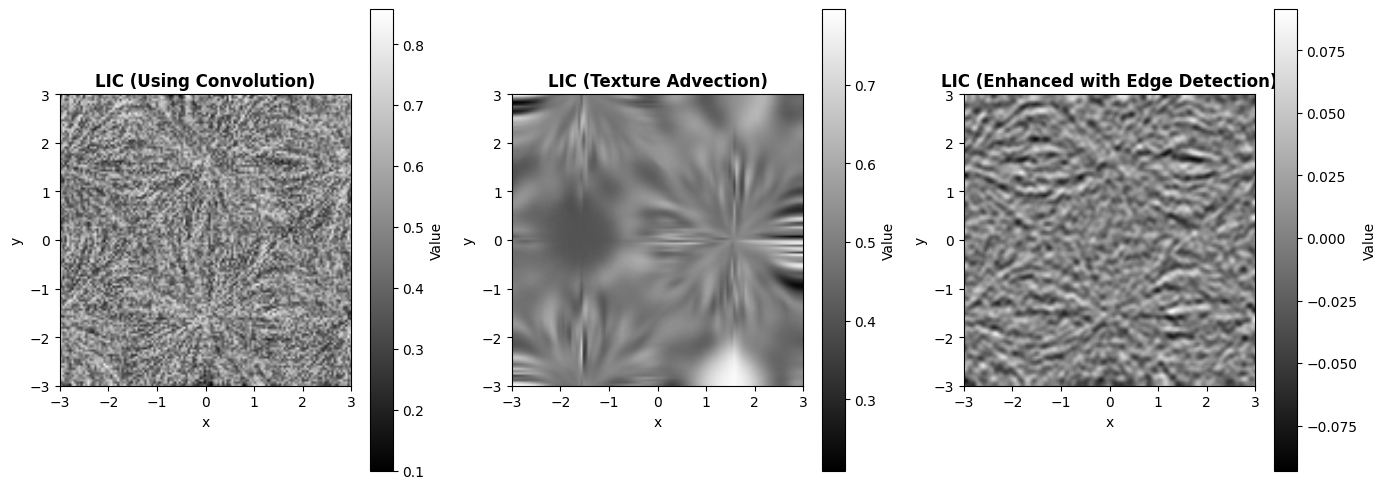

In [92]:
fig, axes = plt.subplots(1, 3, figsize=(14, 5))

lic4 = axes[0].imshow(lic_fast_result, extent=[-3, 3, -3, 3], 
                        origin='lower', cmap='gray', interpolation='bilinear')
axes[0].set_title('LIC (Using Convolution)', fontsize=12, fontweight='bold')
axes[0].set_xlabel('x')
axes[0].set_ylabel('y')
plt.colorbar(lic4, ax=axes[0], label='Value')



lic5 = axes[1].imshow(lic_adv_result, extent=[-3, 3, -3, 3], origin='lower', cmap='gray', interpolation='bilinear')
axes[1].set_title('LIC (Texture Advection)', fontsize=12, fontweight='bold')
axes[1].set_xlabel('x')
axes[1].set_ylabel('y')
plt.colorbar(lic5, ax=axes[1], label='Value')

# Plot 6: Enhanced LIC (with edge enhancement)


lic6 = axes[2].imshow(lic_enhanced, extent=[-3, 3, -3, 3], origin='lower', cmap='gray', interpolation='bilinear')
axes[2].set_title('LIC (Enhanced with Edge Detection)', fontsize=12, fontweight='bold')
axes[2].set_xlabel('x')
axes[2].set_ylabel('y')
plt.colorbar(lic6, ax=axes[2], label='Value')

plt.tight_layout()
plt.savefig('auto_grad_LIC.png', dpi=300, bbox_inches='tight')
plt.show()

# 3. A Simple Neural Network Using `nn.Module` for Classification using Synthetic Dataset

In [149]:
import torch
import torch.nn as nn
import torch.optim as optim

n_samples = 500 # number of samples
d_features = 2 # number of features for each sample

# X = torch.randn(n_samples, d_features, dtype=torch.float32, device=device) # feature matrix
X = torch.normal(mean=1.0, std=0.34, size=(n_samples, d_features),  dtype=torch.float32, device=device)
Y = (X.sum(axis = 1, keepdim=True) > 2).float() # label
Y = Y.to(device)
class SimpleNN(nn.Module):
    def __init__(self, in_features):
        super(SimpleNN, self).__init__()
        self.in_features = in_features
        self.fc1 = nn.Linear(self.in_features, 3)
        self.fc2 = nn.Linear(3, 4)
        self.fc3 = nn.Linear(4, 5)
        self.fc4 = nn.Linear(5, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.fc4(x)
        return x

model = SimpleNN(in_features = d_features).to(device)

# Define the loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)


# Train the model
epochs = 10000

losses = torch.zeros(epochs, device=device)
accuracies = torch.zeros(epochs, device=device)

def accuracy(y_pred, y_true):
    predictions = (y_pred > 0.5).float()
    correct = (predictions == y_true).float()
    return torch.mean(correct).item()

for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = model(X)
    loss = criterion(outputs, Y)
    loss.backward()
    
    losses[epoch] = loss
    accuracies[epoch] = accuracy(outputs, Y)
    optimizer.step()
    if (epoch + 1) % 100 == 0:
        print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()}')
        print(f'GPU Memory: {torch.cuda.memory_allocated() / 1024**2:.5f} MB')

Epoch 100/10000, Loss: 0.6919352412223816
GPU Memory: 18.11865 MB
Epoch 200/10000, Loss: 0.6917145252227783
GPU Memory: 18.11865 MB
Epoch 300/10000, Loss: 0.6914831399917603
GPU Memory: 18.11865 MB
Epoch 400/10000, Loss: 0.6911752820014954
GPU Memory: 18.11865 MB
Epoch 500/10000, Loss: 0.6907764077186584
GPU Memory: 18.11865 MB
Epoch 600/10000, Loss: 0.6902999877929688
GPU Memory: 18.11865 MB
Epoch 700/10000, Loss: 0.689730703830719
GPU Memory: 18.11865 MB
Epoch 800/10000, Loss: 0.6890392303466797
GPU Memory: 18.11865 MB
Epoch 900/10000, Loss: 0.6881990432739258
GPU Memory: 18.11865 MB
Epoch 1000/10000, Loss: 0.6872752904891968
GPU Memory: 18.11865 MB
Epoch 1100/10000, Loss: 0.6862550377845764
GPU Memory: 18.11865 MB
Epoch 1200/10000, Loss: 0.6851479411125183
GPU Memory: 18.11865 MB
Epoch 1300/10000, Loss: 0.6839184761047363
GPU Memory: 18.11865 MB
Epoch 1400/10000, Loss: 0.6825369000434875
GPU Memory: 18.11865 MB
Epoch 1500/10000, Loss: 0.680993914604187
GPU Memory: 18.11865 MB
Epoch 

/tmp/ipykernel_71874/2702972667.py:23: DeprecationWarning:

__array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword



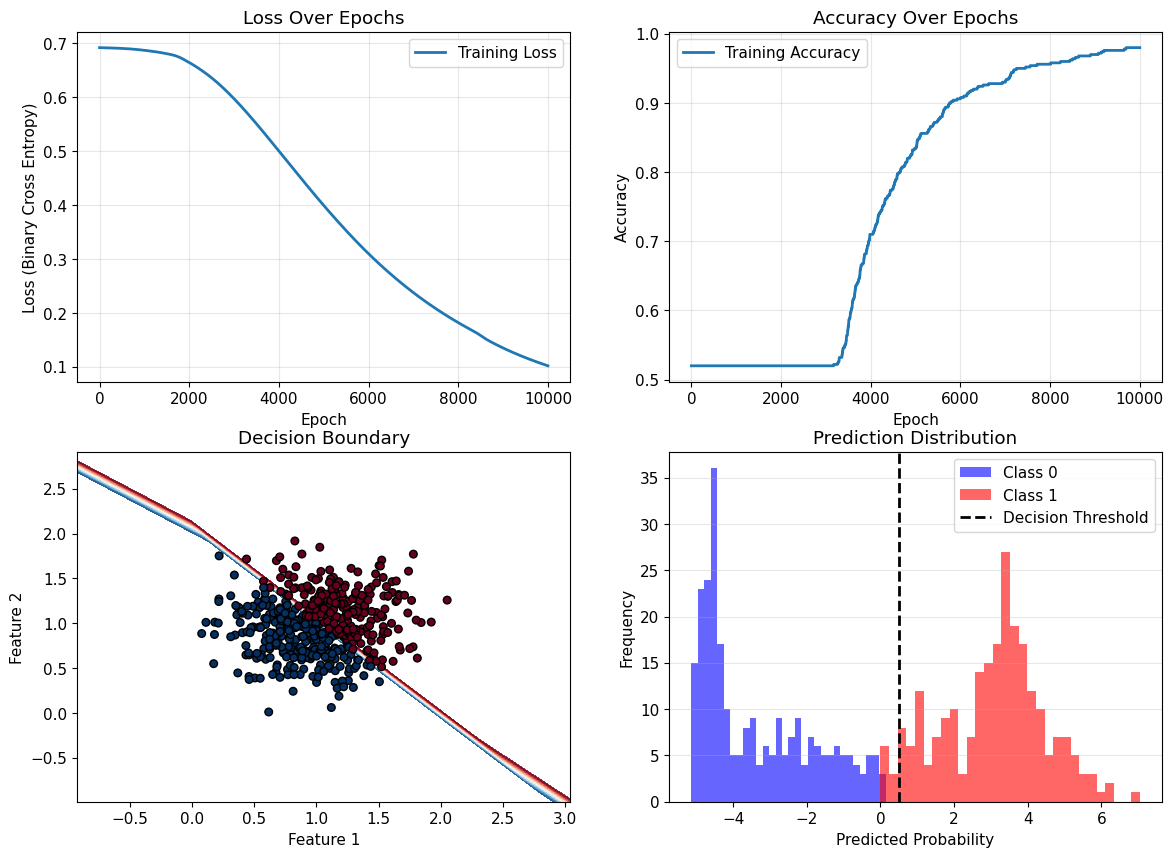

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
plt.rcParams['font.size'] = 11
# Plot 1: Training  Loss
axes[0, 0].plot(losses.cpu().detach().numpy(), label='Training Loss', linewidth=2)
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss (Binary Cross Entropy)')
axes[0, 0].set_title('Loss Over Epochs')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].plot(accuracies.cpu().detach().numpy(), label='Training Accuracy', linewidth=2)
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].set_title('Accuracy Over Epochs')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Decision Boundary (if 2D data)
if d_features == 2:
    h = 0.02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min.cpu(), x_max.cpu(), h), np.arange(y_min.cpu(), y_max.cpu(), h))
    
    mesh_points = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32).to(device)
    
    # no_grad() is required when you want to make prediction (aka doing inference)
    with torch.no_grad():
        Z = model(mesh_points).cpu().numpy()
    Z = Z.reshape(xx.shape)
    
    axes[1, 0].contourf(xx, yy, Z, levels=np.linspace(0, 1, 20), cmap='RdBu_r', alpha=0.8)
    axes[1, 0].scatter(X[:, 0].cpu().numpy(), X[:, 1].cpu().numpy(), c=Y.cpu().numpy().ravel(), cmap='RdBu_r', edgecolors='black', s=30)
    axes[1, 0].set_xlabel('Feature 1')
    axes[1, 0].set_ylabel('Feature 2')
    axes[1, 0].set_title('Decision Boundary')
    axes[1, 0].set_xlim(xx.min(), xx.max())
    axes[1, 0].set_ylim(yy.min(), yy.max())
    
    # Plot 4: Prediction distribution
    with torch.no_grad():
        y_train_pred_final = model(X).cpu().numpy()

    axes[1, 1].hist(y_train_pred_final[Y.cpu().numpy().ravel() == 0], bins=30, alpha=0.6, label='Class 0', color='blue')
    axes[1, 1].hist(y_train_pred_final[Y.cpu().numpy().ravel() == 1], bins=30, alpha=0.6, label='Class 1', color='red')
    axes[1, 1].axvline(0.5, color='black', linestyle='--', linewidth=2, label='Decision Threshold')
    axes[1, 1].set_xlabel('Predicted Probability')
    axes[1, 1].set_ylabel('Frequency')
    axes[1, 1].set_title('Prediction Distribution')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3, axis='y')

    
    

You may observe that classes might be imbalanced in some scenario

In [146]:
X.detach().cpu().numpy()[1]

array([2.1425807 , 0.21792665], dtype=float32)

# 4. A Simple Neural Network Using `nn.Module` for Regression using Synthetic Dataset

In [162]:
import torch
import torch.nn as nn
import torch.optim as optim

n_samples = 500 # number of samples
d_features = 2 # number of features for each sample


# Synthetically generate your training samples

X = torch.normal(mean=12.0, std=4, size=(n_samples, d_features),  dtype=torch.float32, device=device)

m = 1
# Project to m dimensions
projection_matrix = torch.randn(d_features, m, dtype=torch.float32, device=device)
X_proj = X @ projection_matrix  # Shape: (500, m)

# Apply nonlinear function to projection

Y = (X_proj[:, 0]**2 + torch.randn(n_samples, device=device) * 0.1)

# Y = (X_proj[:, 0]**2 + torch.sin(X_proj[:, 1]) + torch.exp(-X_proj[:, 2]**2) + torch.randn(n_samples, device=device) * 0.1)
Y = Y.unsqueeze(1)

class SimpleNN(nn.Module):
    def __init__(self, in_features):
        super(SimpleNN, self).__init__()
        self.in_features = in_features
        self.fc1 = nn.Linear(self.in_features, 3)
        self.fc2 = nn.Linear(3, 4)
        self.fc3 = nn.Linear(4, 5)
        self.fc4 = nn.Linear(5, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.fc4(x)
        return x

model = SimpleNN(in_features = d_features).to(device)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)


# Train the model
epochs = 100000

losses = torch.zeros(epochs, device=device)

def accuracy(y_pred, y_true):
    predictions = (y_pred > 0.5).float()
    correct = (predictions == y_true).float()
    return torch.mean(correct).item()

for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = model(X)
    loss = criterion(outputs, Y)
    loss.backward()
    
    losses[epoch] = loss
    optimizer.step()
    if (epoch + 1) % 1000 == 0:
        print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()}')
        print(f'GPU Memory: {torch.cuda.memory_allocated() / 1024**2:.5f} MB')

Epoch 1000/100000, Loss: 125470.265625
GPU Memory: 18.39062 MB
Epoch 2000/100000, Loss: 121735.8125
GPU Memory: 18.39062 MB
Epoch 3000/100000, Loss: 113859.4296875
GPU Memory: 18.39062 MB
Epoch 4000/100000, Loss: 101030.3125
GPU Memory: 18.39062 MB
Epoch 5000/100000, Loss: 83654.609375
GPU Memory: 18.39062 MB
Epoch 6000/100000, Loss: 63700.44921875
GPU Memory: 18.39062 MB
Epoch 7000/100000, Loss: 44672.265625
GPU Memory: 18.39062 MB
Epoch 8000/100000, Loss: 30720.62890625
GPU Memory: 18.39062 MB
Epoch 9000/100000, Loss: 24061.392578125
GPU Memory: 18.39062 MB
Epoch 10000/100000, Loss: 22085.634765625
GPU Memory: 18.39062 MB
Epoch 11000/100000, Loss: 20810.1328125
GPU Memory: 18.39062 MB
Epoch 12000/100000, Loss: 19367.279296875
GPU Memory: 18.39062 MB
Epoch 13000/100000, Loss: 17827.265625
GPU Memory: 18.39062 MB
Epoch 14000/100000, Loss: 16264.408203125
GPU Memory: 18.39062 MB
Epoch 15000/100000, Loss: 14735.7470703125
GPU Memory: 18.39062 MB
Epoch 16000/100000, Loss: 13276.7578125
GP

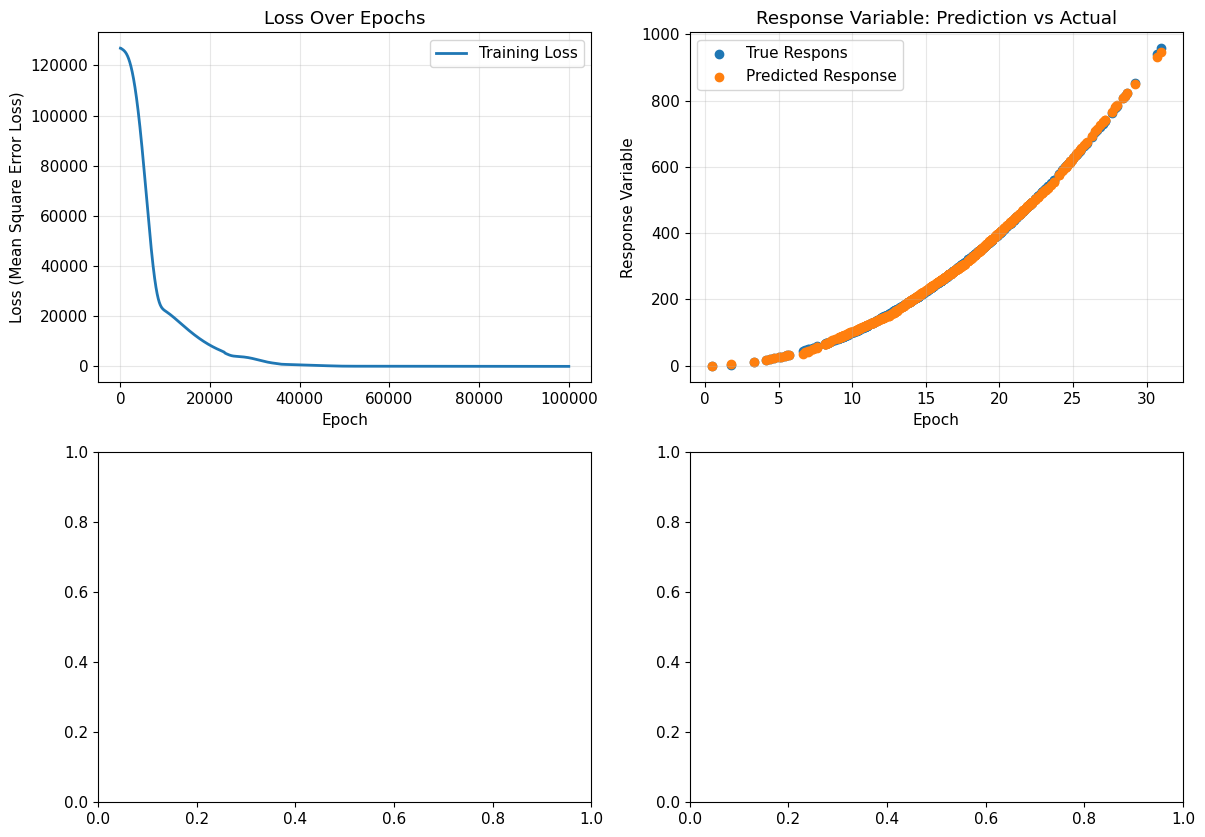

In [164]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
plt.rcParams['font.size'] = 11
# Plot 1: Training  Loss
axes[0, 0].plot(losses.cpu().detach().numpy(), label='Training Loss', linewidth=2)
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss (Mean Square Error Loss)')
axes[0, 0].set_title('Loss Over Epochs')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

with torch.no_grad():
    Y_pred = model(X).cpu().numpy()
        
axes[0, 1].scatter(X_proj[:, 0].cpu().detach().numpy(), Y.cpu().detach().numpy(), label='True Respons')
axes[0, 1].scatter(X_proj[:, 0].cpu().detach().numpy(), Y_pred, label='Predicted Response')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Response Variable')
axes[0, 1].set_title('Response Variable: Prediction vs Actual')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)